<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code/2_Map_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code file we perform the Map Matching operation. In other words, we are trying to map every GPS record to the actual position inside the road network.

The reasons for such a process are many:

1.   Technical problems with the sensors that may occur
2.   Noise while data collection

It is important to note that this process requires substantial computational power and time resources. On the dataset we use, the execution time for this procedure typically extends to approximately 68 hours. Additionally, the output file of 6 GB that was produced during this operation is not included in our repository for accessibility reasons.


In [1]:
# Handle data files
import pandas as pd

# These libraries are essential for the communication with the Map Matching API
import json
import random
import requests

# Handle timestamp values
from datetime import timedelta

In [ ]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Read split trajectory data
all_data = pd.read_csv('/content/drive/MyDrive/Paper/splitted_data.csv')

In [ ]:
# Sort all data
all_data = all_data.sort_values(['taxi_id','traj_id','Date Time'])
all_data = all_data.reset_index(drop=True)

In [ ]:
# Convert string values to datetime
all_data['Date Time'] = pd.to_datetime(all_data['Date Time'])

In [ ]:
# Pass latitude and longitude pairs to Valhalla API
df_for_meili = all_data[['Latitude','Longitude']]
df_for_meili = df_for_meili.rename(columns={"Latitude": "lat", "Longitude": "lon"})

**What is Map Matching?**

Map matching is a process used in geographical information systems (GIS) and navigation systems to align or match a sequence of spatial data points (usually obtained from GPS or other positioning systems) within a digital map. The goal of map matching is to determine the most likely coordinate that each spatial data point is located.

**How map matching is usefull in this research?**

Working with traffic data, there is always the possibility that its collection process to contains errors. This is beacuse of a error occured with the sampling sensor or another technical error. For this reason, in this research, our data are filtered using a Map Matching algorithm.

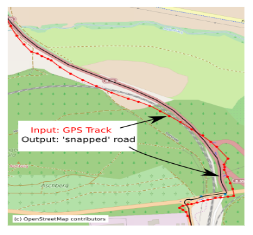

For example, imagine that we have data GPS points of a trajectory (the red one). If this trajectory is a route of a vehicle, then it is clearly understood that these data are mismatched. A Map Matching algorithm receives as input the red trajectory and produces the black trajectory as output.


**Map matching done using Valhalla Meili API.**

Supplying individual trajectories to the API yields responses containing precise details about the edges traversed by each trajectory. The order of these edges corresponds to the correct sequence of access. The sequential arrangement of edges collectively forms a path, with each edge identified by its respective OSM Way ID.

**Sources:**

[Valhalla Meili API (documentation)](https://valhalla.github.io/valhalla/api/map-matching/api-reference/#matched-point-items)

[How to install Valhalla API on ubuntu using Docker](https://ikespand.github.io/posts/meili/)

In [ ]:
# Define a new dataframe to store the Map Matched data
visited_segments = pd.DataFrame(columns=['taxi_id', 'traj_id', 'osm_way_id', 'edge_length', 'edge_speed', 'road_class', 'expected_start_time', 'expected_end_time'])

# For each 'taxi_id' in the dataset
for taxi_id in all_data['taxi_id'].unique():

    # For each 'traj_id' in the dataset
    for traj_id in all_data[all_data['taxi_id'] == taxi_id]['traj_id'].unique():

        # Get the batch of data that we send to the request
        indexes = all_data[(all_data['taxi_id']==taxi_id) & (all_data['traj_id'] == traj_id)].index

        # Input to API
        passed_data = df_for_meili.iloc[indexes]

        # Preparing the request to Valhalla's Meili
        meili_coordinates = passed_data.to_json(orient='records')

        # Head and Tail of the request
        meili_head = '{"shape":'
        meili_tail = ""","search_radius": 200, "sigma_z": 10, "beta": 10,"shape_match":"map_snap", "costing":"auto",
                        "filters":{"attributes":["edge.way_id","edge.speed","edge.length","edge.road_class"],"action":"include"},
                        "format":"osrm"}"""

        # Construction of the the request
        meili_request_body = meili_head + meili_coordinates + meili_tail

        # The URL of the local valhalla server
        url = "http://localhost:8002/trace_attributes"

        # Providing headers to the request
        headers = {'Content-type': 'application/json'}

        # we need to send the JSON as a string
        data = str(meili_request_body)

        # Sending a request to Valhalla Meili API
        r = requests.post(url, data=data, headers=headers)

        # Response from Valhalla API was successful
        if r.status_code == 200:

            # Parse the JSON response
            response_text = json.loads(r.text)

            # Find the time interval (in sec) that the trajectory needs to be completed [last timestamp - first timestamp]
            interval = (all_data.iloc[indexes].iloc[-1]['Date Time'] - all_data.iloc[indexes].iloc[0]['Date Time']).total_seconds()

            # Compute the expected duration that the moving object is in each edge (duration is equal for each edge that the trajectory visits)
            duration  = interval/len(response_text['edges'])

             # Define a temporary dataframe to store temporary information
            temp = pd.DataFrame(columns=['taxi_id', 'traj_id', 'osm_way_id', 'edge_length', 'edge_speed','road_class', 'expected_start_time', 'expected_end_time'])

            # Fill the rows of the dataframe with information that API gave
            for i in range(len(response_text['edges'])):
                temp.at[i,'taxi_id'] = taxi_id # taxi id
                temp.at[i,'traj_id'] = traj_id # traj id
                temp.at[i,'osm_way_id'] = response_text['edges'][i]['way_id'] # osm_way id
                temp.at[i,'edge_speed'] = response_text['edges'][i]['speed'] # speed
                temp.at[i,'edge_length'] = response_text['edges'][i]['length'] # edges length
                temp.at[i,'road_class'] = response_text['edges'][i]['road_class'] # type of edge

                # Time information
                if i == 0:
                    temp.at[i,'expected_start_time'] = all_data.iloc[indexes].iloc[0]['Date Time']
                else:
                    temp.at[i,'expected_start_time'] = temp.at[i-1,'expected_end_time']

                temp.at[i,'expected_end_time'] = temp.at[i,'expected_start_time'] + timedelta(seconds=duration)

            # Concatenate the two dataframes
            visited_segments = pd.concat([visited_segments,temp],ignore_index=True)

During Map Matching, we considered that the time interval that a Yellow Taxi is within each edge is equal for every edge in the trajectory. This concept is wrong.

The following code tries to estimate 'expected_start_time' and 'expected_end_time' for each edge with respect to the length of this edge.

In [ ]:
# For each 'taxi_id' in the dataset
for taxi_id in visited_segments['taxi_id'].unique():

    # For each 'traj_id' within the current 'taxi_id'
    for traj_id in visited_segments[visited_segments['taxi_id'] == taxi_id]['traj_id'].unique():

        # Get the data of a specific trajectory
        current_trajectory = visited_segments[
            (visited_segments['taxi_id'] == taxi_id) & (visited_segments['traj_id'] == traj_id)
        ]

        # Get the indexes of that specific trajectory
        indexes = visited_segments[
            (visited_segments['taxi_id'] == taxi_id) & (visited_segments['traj_id'] == traj_id)
        ].index.to_list()

        # Calculate the sum of lengths of all edges present in this trajectory
        sum_of_lengths = sum(current_trajectory['edge_length'])

        # Create a new column with the percentages of the lengths of each edge to the sum of all edges
        current_trajectory['length_percentage'] = (current_trajectory['edge_length'] / sum_of_lengths)

        # Based on the percentages that we calculated,
        # define the time interval that the vehicle was in a specific edge of the current trajectory
        time_enter_index = current_trajectory.index[0]
        time_leave_index = current_trajectory.index[-1]

        # Compute the whole time interval of the selected trajectory
        complete_interval = (
            current_trajectory.at[time_leave_index, 'expected_end_time']
            - current_trajectory.at[time_enter_index, 'expected_start_time']
        ).seconds

        # Update the start and end times using with respect to the length of each edge
        i = 0
        try:
            for index in indexes:
                if i == 0:
                    # Update 'expected_end_time' for the first index
                    visited_segments.at[index, 'expected_end_time'] = visited_segments.at[index, 'expected_start_time'] + timedelta(seconds=(current_trajectory.at[index, 'length_percentage'] * complete_interval))
                else:
                    # Update 'expected_start_time' and 'expected_end_time' for subsequent indexes
                    visited_segments.at[index, 'expected_start_time'] = visited_segments.at[index - 1, 'expected_end_time']
                    visited_segments.at[index, 'expected_end_time'] = visited_segments.at[index, 'expected_start_time'] + timedelta(seconds=(current_trajectory.at[index, 'length_percentage'] * complete_interval))
                i = i + 1
        except Exception as e:
            print(f'Problem at trajectory:{taxi_id},{traj_id}')
            print(e)
            pass

In [ ]:
# Save data to csv
visited_segments.to_csv('interpolated_data.csv', index=False)